<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Kleines-Beispiel" data-toc-modified-id="Kleines-Beispiel-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Kleines Beispiel</a></span></li></ul></div>

In [1]:
import sys
import os

try:
    os.chdir(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    
import warnings
warnings.filterwarnings("ignore")

In [2]:
import nglview as nv
import MDAnalysis as mda
import numpy as np
import time
import ipywidgets as widgets
from scipy.sparse import csr_array
from numpy.typing import NDArray

from molgri.paths import PATH_OUTPUT_PT, OUTPUT_PLOTTING_DATA, PATH_OUTPUT_LOGGING
from molgri.space.fullgrid import FullGrid

Erstmals: wir brauchen eine HF Monomer Datai.

In [4]:
%pycat input/HF.xyz

Nun lass zwei PTs (klein, groß) produzieren:
- klein: -o 42 -t "linspace(0.1, 0.4, 10)" -b 8
- groß: -o 162 -t "linspace(0.1, 0.4, 20)" -b 40

## Kleines Beispiel
- obtain full grid
- show full grid coordinates per frame in the corner

In [8]:
small_name = "HF_HF_0010"
b_grid = "8"
o_grid = "12"
t_grid = "linspace(0.2, 0.4, 3)"

In [4]:
%run molgri/scripts/generate_pt.py -m1 HF -m2 HF --recalculate -o $o_grid -b $b_grid -t "linspace(0.2, 0.4, 3)"

Saved the log file to output/data/logging/HF_HF_0010.log
Saved pseudo-trajectory to output/data/pt_files/HF_HF_0010.xtc and structure file to output/data/pt_files/HF_HF_0010.gro
Timing the generation of Pt HF_HF_0010: 0:00:00.479715 hours:minutes:seconds


In [17]:
class PTFrameAnalyser:
    
    """
    Visualise frames and important information from PT using NGLView. Reads PTs from saved files.
    """
    
    def __init__(self, u, fg=None):
        """
        Args:
            - name_pt: Name that is given to the PT files, usually in the form <molecule 1>_<molecule 2>_<4-number index>
                       or selected by the user
            - o_input: a string given as user input to create rotations around origin, e.g. "15" or "ico_15"
            - b_input: a string given as user input to create rotations around body, e.g. "42" or "cube4D_42"
            - t_input: a string given as user input to create translations, e.g. "[0.1, 0.2]" or "range(1, 5, 3)"
        """
        self.u = u
        self.fg = fg
        

        
    def _get_neig_indices(self, i: int) -> NDArray:
        """
        Given an index from full grid, get indices of points that are neighbours.
        
        Args:
            - i: index of the point (row in full grid array)
        """
        adj_array = csr_array(self.fg.get_full_adjacency())[:, [i]].toarray().T[0]
        neighbour_indices = np.nonzero(adj_array)[0]
        return neighbour_indices
        
    
    def plot_all_neighours_of_i(self, i: int):
        """
        Given an index from full grid, plot the PT frames corresponding to the neighbouring points.
        
        Args:
            - i: index of the point (row in full grid array)
        """
        neighbour_indices = self._get_neig_indices(i)
        
        # settings that are important so that rows with too many images nicely overflow in the next row
        box = widgets.HBox(layout=widgets.Layout(width='100%',display='inline-flex',flex_flow='row wrap'))
        box.overflow_x = 'auto'
        
        all_views = []
        for neig_i in neighbour_indices:
            # opaque plot of the original structure (point i)
            neig_view = self.plot_ith_frame(i, opacity=0.5)
            # full coverage plot of the neighbour structure
            neig_view = self.plot_ith_frame(neig_i, view=neig_view)
            # this is also important for nice arragement of figures
            neig_view.layout.width = "200px"
            all_views.append(neig_view)
        
        # sync all views (so that all plots move if you move any)
        for v in all_views:
            v._set_sync_camera(all_views)
        
        box.children=[i for i in all_views]
        display(box)
        
                
    def _get_fullgrid_name(self):
        """
        NOT IN USE CURRENTLY
        Read from the .log file to obtain the name of the used FullGrid.
        """
        with open(f"{PATH_OUTPUT_LOGGING}{self.name_pt}.log") as f:
            while True:
                line = f.readline()
                if line.startswith("INFO:PtLogger:full grid name:"):
                    return line.strip().split(": ")[-1]
        
    
    def get_ith_frame(self, i: int) -> mda.Universe:
        """
        Get the Universe object containing of all the atoms in the PT but only a single frame (i-th frame).
        """
        self.u.trajectory[i]
        all_atoms = self.u.select_atoms('all')
        new_u = mda.Merge(self.u.atoms)
        return new_u

    
    def plot_side_by_side(self, view1, view2):
        """
        Plot two NGLView views side by side.
        
        """
        # Adjust layout to center both molecules
        view1.layout.width = 'auto'
        view2.layout.width = 'auto'
        view1._set_sync_camera([view2])
        view2._set_sync_camera([view1])


        hbox = widgets.HBox([view1, view2])
        
                
        # TODO: link cameras of both views
        mylink = widgets.jslink((view1, 'frame'), (view2, 'frame'))

        # Display the HBox
        display(hbox)

    
    def _add_coordinate_axes(self, view):
        """
        Add the x, y and z axes at origin to a NGLView.
        """
        
        # arguments of add_arrow are: start position, end position, color (in RGB), radius of arrow head
        # arguments of add_label are: position, color (in RGB), size, text
        
        # X-axis is red
        view.shape.add_arrow([0, 0, 0], [1, 0, 0],[ 1, 0, 0 ], 0.1)
        view.shape.add_label([1, 0, 0], [1, 0, 0], 1.5, 'x')
        
        # Y-axis is green
        view.shape.add_arrow([0, 0, 0], [0, 1, 0],[0, 1, 0 ], 0.1)
        view.shape.add_label([0, 1, 0], [0, 1, 0], 1.5, 'y')
        
        # Z-axis is blue
        view.shape.add_arrow([0, 0, 0], [0, 0, 1],[0, 0, 1 ], 0.1)
        view.shape.add_label([0, 0, 1], [0, 0, 1], 1.5, 'z')

    def plot_ith_frame(self, i: int, view=None, axes: bool = True, **kwargs):
        """
        Plot i-th frame of PT
        
        Args:
            - i: index of the point (row in full grid array)
            - view: if NGLView is given, a new figure will be added to it; else a new view is created
            - axes: if True, draw x, y and z axes
        """
        ith_atoms = self.get_ith_frame(i)
        
        if view is None:
            view = nv.show_mdanalysis(ith_atoms, default_representation=False)
            view.add_ball_and_stick(**kwargs)
        else:
            view.add_component(ith_atoms, **kwargs)
        if axes:
            self._add_coordinate_axes(view)
        
        return view
    
    def print_ith_information(self, i):
        """
        Print out important information about the i-th point of PT
        """
        all_points = self.fg.get_full_grid_as_array()
        ith_fg_coo = np.array2string(all_points[i], precision=2, suppress_small=True, separator=",")
        print(f"Frame {i}")
        print(f"FullGrid coordinates {ith_fg_coo}")
        
        neighbours = self._get_neig_indices(i)
        print(f"The point {i} has {len(neighbours)} neighbours, here is the list:")
        for n_index in neighbours:
            print(np.array2string(all_points[n_index], precision=2, suppress_small=True, separator=","))

def create_u_for_PT(name_pt: str, o_input: str, b_input: str, t_input: str):
    u = mda.Universe(f"{PATH_OUTPUT_PT}{self.name_pt}.gro", f"{PATH_OUTPUT_PT}{self.name_pt}.xtc")
    fg = FullGrid(o_grid_name=o_input, b_grid_name=b_input, t_grid_name=t_input, use_saved=True)
    _check_grid_correct(name_pt, fg)
    return u, fg

def _check_grid_correct(self, name_pt, fg):
    """
    Since we re-construct the FullGrid object to access all of its methods, we perform a quick check that the
    newly constructed grid actually has the same coordinates as the grid that has been saved during construction
    of the pseudotrajectory.
    """
    # first step: read the name of the full grid from a PT log file
    with open(f"{PATH_OUTPUT_LOGGING}{name_pt}.log") as f:
        while True:
            line = f.readline()
            if line.startswith("INFO:PtLogger:full grid name:"):
                full_grid_name = line.strip().split(": ")[-1]
                break

    # second step: load the .npy file with the found name
    used_grid = np.load(f"{OUTPUT_PLOTTING_DATA}get_full_grid_as_array_{full_grid_name}.npy")

    # third step: assert that this is actually the grid that has been used
    assert np.allclose(used_grid, fg.get_full_grid_as_array())
    



In [ ]:
pta = PTFrameAnalyser(*create_u_for_PT(small_name, b_input=b_grid, o_input=o_grid, t_input=t_grid))
#view1 = pta.plot_ith_frame(15)
#view2 = pta.plot_ith_frame(75)
#pta.plot_side_by_side(view1, view2)
pta.print_ith_information(5)
pta.plot_all_neighours_of_i(5)

In [ ]:
view1 = pta.plot_ith_frame(15)
view2 = pta.plot_ith_frame(75)

In [ ]:
pta.plot_side_by_side(view1, view2)

- plot neighbours
- plot structures with largest phasespace volumes

In [89]:
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display

num_checks = 50

cb_cont = HBox(layout=Layout(width='100%',display='inline-flex',flex_flow='row wrap'))
#cb_cont.overflow_x = 'scroll'

checkboxes = []
for f in range(num_checks):
    checkboxes.append(\
        widgets.Checkbox(description = 'Checkbox [%d]'%(f), \
                     value=False, width=50))

cb_cont.children=[i for i in checkboxes]
display(cb_cont)


In [5]:
# großeres beispiel
big_name = "HF_HF_0011"
b_grid_b = "272"
o_grid_b = "162"
t_grid_b = "linspace(0.1, 0.4, 20)"

In [4]:
%run molgri/scripts/generate_pt.py -m1 HF -m2 HF --recalculate -o $o_grid_b -b $b_grid_b -t "linspace(0.1, 0.4, 20)"

Saved the log file to output/data/logging/HF_HF_0011.log
Saved pseudo-trajectory to output/data/pt_files/HF_HF_0011.xtc and structure file to output/data/pt_files/HF_HF_0011.gro
Timing the generation of Pt HF_HF_0011: 0:24:59.522670 hours:minutes:seconds


In [11]:
pta = PTFrameAnalyser(big_name, b_input=b_grid_b, o_input=o_grid_b, t_input=t_grid_b)

pta.print_ith_information(500)
pta.plot_all_neighours_of_i(500)

In [3]:
%run molgri/scripts/generate_pt.py -m1 H2O -m2 H2O --recalculate -o "162" -b "272" -t "linspace(0.1, 0.4, 20)"

Saved the log file to output/data/logging/H2O_H2O_0092.log
Saved pseudo-trajectory to output/data/pt_files/H2O_H2O_0092.xtc and structure file to output/data/pt_files/H2O_H2O_0092.gro
Timing the generation of Pt H2O_H2O_0092: 0:25:25.037286 hours:minutes:seconds


In [ ]:
#WATER

In [27]:
from MDAnalysis import transformations

u = mda.Universe(r"/home/hanaz63/nobackup/gromacs/H2O_H2O_0095_10000/H2O_H2O_0095.gro", 
                 r"/home/hanaz63/nobackup/gromacs/H2O_H2O_0095_10000/output.xtc")

#reconnect molecules


ag = u.atoms
# we will use mass as weights for the center calculation
workflow = (transformations.center_in_box(ag, center='mass'),)
u.trajectory.add_transformations(*workflow)


v = nv.show_mdanalysis(u)
v.add_unitcell()
v

NGLWidget(max_frame=10000)

In [3]:
from molgri.molecules.parsers import XVGParser

        

my_parser = XVGParser(r"/home/hanaz63/nobackup/gromacs/H2O_H2O_0095_10000/full_energy.xvg")
potentials = my_parser.get_parsed_energy()

print(potentials.labels)


('None', 'LJ (SR)', 'Disper. corr.', 'Coulomb (SR)', 'Potential')


In [30]:
pta = PTFrameAnalyser(u)
pta.plot_ith_frame(min_frame)

NGLWidget()

In [37]:
my_parser = XVGParser(r"/home/hanaz63/nobackup/gromacs/H2O_H2O_0096/H2O_H2O_0096.xvg")
potentials = my_parser.get_parsed_energy().get_energies("Disper. corr.")
min_frame = np.argmin(potentials)
min_frame

432

In [5]:
%matplotlib notebook

In [6]:
from molgri.molecules.transitions import SimulationHistogram, MSM
from molgri.plotting.molecule_plots import TrajectoryPlot
import pandas as pd
import matplotlib.pyplot as plt
from molgri.molecules.parsers import FileParser, ParsedEnergy
from molgri.molecules.parsers import XVGParser


my_num = "0098"
len_traj = "10000"

# preparing the parsed trajectory
my_parser = XVGParser(f"/home/hanaz63/nobackup/gromacs/H2O_H2O_{my_num}/H2O_H2O_{my_num}.xvg")
pe = my_parser.get_parsed_energy() #.get_energies("Disper. corr.")
pt_parser = FileParser(
    path_topology=f"/home/hanaz63/nobackup/gromacs/H2O_H2O_{my_num}/H2O_H2O_{my_num}.gro",
    path_trajectory=f"/home/hanaz63/nobackup/gromacs/H2O_H2O_{my_num}/H2O_H2O_{my_num}.xtc")
parsed_trajectory = pt_parser.get_parsed_trajectory(default_atom_selection="bynum 4:6")
parsed_trajectory.energies = pe


print(pe.get_energies("Potential"))
# preparing the grid
#fg = FullGrid(t_grid_name="[0.1, 0.2, 0.3]", o_grid_name="ico_42", b_grid_name="cube4D_16")

#sh = SimulationHistogram(parsed_trajectory, fg)
#my_msm = MSM(sh, tau_array=np.array([10, 50, 100]), use_saved=False)

[ 6.35023376e+02  5.95563599e+02  8.76023682e+02 ... -1.57217300e+00
  2.87927500e+00  1.67389000e-01]


<IPython.core.display.Javascript object>


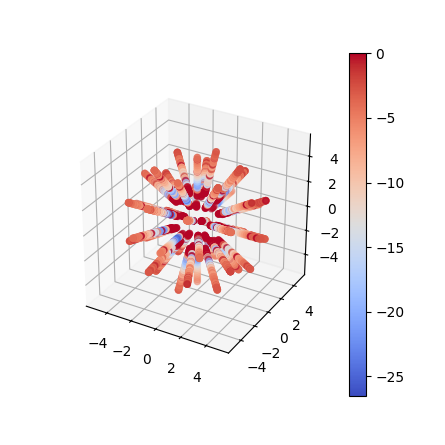

In [8]:
tp = TrajectoryPlot(parsed_trajectory)
tp.plot_energy_COM(save=False, vmax=0)
plt.show()

In [16]:
print(np.argmin(pe.get_energies("Potential")))
print(pe.get_energies("Potential")[9907])
print(pe.get_energies("LJ (SR)")[9907])
print(pe.get_energies("Coulomb (SR)")[9907])


9907
-26.530365
5.883503
-34.884674


In [20]:
u=mda.Universe(f"/home/hanaz63/nobackup/gromacs/H2O_H2O_{my_num}/H2O_H2O_{my_num}.gro",
                                    f"/home/hanaz63/nobackup/gromacs/H2O_H2O_{my_num}/H2O_H2O_{my_num}.xtc")
pta = PTFrameAnalyser(u)
pta.plot_ith_frame(9907)

NGLWidget()

In [23]:
from MDAnalysis.analysis import distances
u.trajectory[9907]
distances.self_distance_array(u.atoms.positions)

array([0.96000004, 0.95078911, 2.78406147, 3.2157585 , 3.40340442,
       1.51208467, 1.82492291, 2.30349723, 2.47760024, 3.13296422,
       3.70629721, 3.76476702, 0.95990578, 0.95082966, 1.5120597 ])